In [1]:
import math
import numpy as np
import pymc3 as pm
from tqdm.notebook import tqdm
from tensorflow_privacy.privacy.optimizers.dp_optimizer import *
import pandas as pd
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import random; random.seed(42)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import tensorflow as tf

%load_ext autoreload
%autoreload 2

tf.compat.v1.enable_eager_execution()
assert tf.executing_eagerly

Using TensorFlow backend.


In [2]:
epochs = 1
batch_size = 100

DP-SGD has three privacy-specific hyperparameters and one existing hyperamater that you must tune:

1. `l2_norm_clip` (float) - The maximum Euclidean (L2) norm of each gradient that is applied to update model parameters. This hyperparameter is used to bound the optimizer's sensitivity to individual training points. 
2. `noise_multiplier` (float) - The amount of noise sampled and added to gradients during training. Generally, more noise results in better privacy (often, but not necessarily, at the expense of lower utility).
3.   `microbatches` (int) - Each batch of data is split in smaller units called microbatches. By default, each microbatch should contain a single training example. This allows us to clip gradients on a per-example basis rather than after they have been averaged across the minibatch. This in turn decreases the (negative) effect of clipping on signal found in the gradient and typically maximizes utility. However, computational overhead can be reduced by increasing the size of microbatches to include more than one training examples. The average gradient across these multiple training examples is then clipped. The total number of examples consumed in a batch, i.e., one step of gradient descent, remains the same. The number of microbatches should evenly divide the batch size. 

In [3]:
l2_norm_clip = 0.5
noise_multiplier = 1
gaussian_stdev = l2_norm_clip * noise_multiplier
gaussian_noise_var = gaussian_stdev ** 2
public_var_multiplier = 1 # Multiply public variance by this multiplier
public_stdev_multipler = math.sqrt(public_var_multiplier)
num_microbatches = batch_size

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [4]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255
train_data = np.expand_dims(train_data, len(train_data.shape))
test_data = np.expand_dims(test_data, len(test_data.shape))

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

In [5]:
from sklearn.model_selection import train_test_split

# test_size refers to private data size
public_data, private_data, public_labels, private_labels = \
    train_test_split(train_data, train_labels, test_size=199/200)

num_batches = private_data.shape[0] // batch_size

In [6]:
print(public_data.shape)
print(public_labels.shape)
print(private_data.shape)
print(private_labels.shape)

(300, 28, 28, 1)
(300, 10)
(59700, 28, 28, 1)
(59700, 10)


In [7]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

compute_dp_sgd_privacy.compute_dp_sgd_privacy(
    n=private_labels.shape[0], batch_size=batch_size, noise_multiplier=noise_multiplier, epochs=epochs, delta=1e-5)

DP-SGD with sampling rate = 0.168% and noise_multiplier = 1 iterated over 597 steps satisfies differential privacy with eps = 1.07 and delta = 1e-05.
The optimal RDP order is 12.0.


(1.0661600902513837, 12.0)

In [8]:
# CNN model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# ~3k parameters, ~80% accuracy
def cnn_model():
    model = tf.keras.models.Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.load_weights('mnist_tiny_initial_weights.h5')
    return model

print(cnn_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3140      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50        
Total params: 3,190
Trainable params: 3,190
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def construct_graphical_model_and_get_map(public_grads, dp_grads):
    num_parameters_by_layer = [l.shape[0] for l in dp_grads]
    weights_and_biases_by_layer = list(chunks(num_parameters_by_layer, 2))
    public_weights_and_biases_by_layer = list(chunks(num_parameters_by_layer, 2))
    weights_by_layer = [params[0] for params in weights_and_biases_by_layer]
    weights_beginning_index_by_layer = np.append([0], weights_by_layer[:-1])
    
    map_grads = [np.zeros_like(l) for l in dp_grads]
    grad_name_mapping = {}
    
    graphical_model = pm.Model()
    bias_idx = 0
    weight_idx = 0
    
    for layer_num, layer in enumerate(tqdm(dp_grads, desc='Graph Layer', leave=False)):
        it = np.nditer(layer, flags=['multi_index'])
        
        for _ in tqdm(it, desc='Graph Weight', leave=False, total=dp_grads[layer_num].size):
            public_grads_layer = public_grads[layer_num][(slice(None), *it.multi_index)]
            public_grads_mean = np.mean(public_grads_layer)
            public_grads_stdev = np.std(public_grads_layer, ddof=1) * public_stdev_multipler
            public_grads_var = public_grads_stdev ** 2
            dp_grad = it[0]
            
            # MAP for two Gaussians is
            # ((variance * observed) + (gaussian_noise_var * mean)) / (variances + gaussian_noise_var)
            if layer_num % 2 == 1: # Bias
                map_estimate = ((public_grads_var * dp_grad) + (public_grads_mean * gaussian_noise_var)) \
                                / (public_grads_var + gaussian_noise_var)
                map_grads[layer_num][it.multi_index] = map_estimate
                grad_name_mapping[f"bias_{bias_idx}"] = (layer_num, it.multi_index)
                with graphical_model:
                    exec(f"bias_{bias_idx} = pm.Normal('bias_{bias_idx}', \
                            mu=public_grads_mean, sigma=public_grads_stdev)")
                    exec(f"bias_observed_{bias_idx} = pm.Normal('bias_observed_{bias_idx}', \
                             mu=weight_{bias_idx}, sigma=gaussian_stdev, observed=dp_grad)")
                bias_idx += 1
                
            else:  # Weight
                weight_layer_num = layer_num // 2
                grad_name_mapping[f"weight_{weight_idx}"] = (layer_num, it.multi_index)
                if weight_layer_num == 0:
                    with graphical_model:
                        exec(f"weight_{weight_idx} = pm.Normal('weight_{weight_idx}', \
                                mu=public_grads_mean, sigma=public_grads_stdev)")
                        exec(f"weight_observed_{weight_idx} = pm.Normal('weight_observed_{weight_idx}', \
                                 mu=weight_{weight_idx}, sigma=gaussian_stdev, observed=dp_grad)")
                else:
                    neuron_idx = it.multi_index[0]
                    upstream_weights = public_grads[layer_num-2][:, :, neuron_idx]
                    num_upstream_weights = upstream_weights.shape[1]
                    coeffs = np.linalg.lstsq(upstream_weights, public_grads_layer, rcond=None)[0]
                    
                    upstream_weight_starting_index = weights_beginning_index_by_layer[weight_layer_num-1] \
                                                        + neuron_idx * num_upstream_weights
                    upstream_weight_ending_index = upstream_weight_starting_index + num_upstream_weights
                    upstream_weight_indices = range(upstream_weight_starting_index,
                                                    upstream_weight_ending_index)
                    upstream_weight_coeff_strings = [f'{coeff} * weight_{idx}' 
                                                         for (coeff, idx) in zip(coeffs, upstream_weight_indices)]
                    combined_string = ' + '.join(upstream_weight_coeff_strings)
                    with graphical_model:
                        exec(f"weight_{weight_idx} = pm.Normal('weight_{weight_idx}', \
                                mu={combined_string}, sigma=public_grads_stdev)")
                        exec(f"weight_observed_{weight_idx} = pm.Normal('weight_observed_{weight_idx}', \
                                 mu=weight_{weight_idx}, sigma=gaussian_stdev, observed=dp_grad)")
                weight_idx += 1

    map_estimates = pm.find_MAP(model=graphical_model, progressbar=False)
    for key, value in map_estimates.items():
        layer_num, idx = grad_name_mapping[key]
        map_grads[layer_num][idx] = value

    return map_grads

In [10]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [11]:
def get_public_grads(public_x, public_y, loss_fn, model):
    public_grads = []
    # x needs to have extra dimension for number of examples,
    # even if it's 1 for our case
    public_x = np.expand_dims(public_x, axis=1)
    for x, y in zip(public_x, public_y):
#     for x, y in tqdm(zip(public_x, public_y), total=public_x.shape[0], desc='Public Dataset Iter'):
        with tf.GradientTape() as tape:
            loss_value = loss_fn(y, model(x))
            grad = tape.gradient(loss_value, model.trainable_weights)
        if not public_grads:
            public_grads = [[] for _ in grad]
        for i, t in enumerate(grad):
            public_grads[i].append(t.numpy())
    public_grads = [np.asarray(l) for l in public_grads]
    return public_grads

def get_public_grads_mean_var(public_x, public_y, loss_fn, model):
    # x needs to have extra dimension for number of examples,
    # even if it's 1 for our case
    public_x = np.expand_dims(public_x, axis=1)
    # https://math.stackexchange.com/questions/20593/calculate-variance-from-a-stream-of-sample-values
    mean_k = None
    v_k = None
    k = 0
    for x, y in zip(public_x, public_y):
        k += 1
        with tf.GradientTape() as tape:
            loss_value = loss_fn(y, model(x))
            grad = tape.gradient(loss_value, model.trainable_weights)
        numpy_grad = [t.numpy() for t in grad]
        if k == 1:
            mean_k = numpy_grad
            v_k = [np.zeros(t.shape) for t in numpy_grad]
        else:
            prev_mean_k = mean_k
            mean_k = [mean_k[i] + (t - mean_k[i]) / k for i, t in enumerate(numpy_grad)]
            v_k = [v_k[i] +  np.multiply(t - prev_mean_k[i], 
                                         t - mean_k[i]) 
                   for i, t in enumerate(numpy_grad)]
    unbiased_variance = [t / (k - 1) for t in v_k]
    return mean_k, unbiased_variance

def evaluate_model(model, loss_fn, x, y):
    pred = model(x)
    loss = np.mean(loss_fn(y, pred).numpy())
    acc = np.mean(tf.keras.metrics.categorical_accuracy(y, pred).numpy())
    return (loss, acc)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

pretrained_model = cnn_model()
pretrained_model.compile(optimizer='adam',
                       loss=loss_fn, metrics=['accuracy'])
baseline_history = pretrained_model.fit(public_data, public_labels,
                    epochs=50,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[TQDMNotebookCallback(), EarlyStopping(monitor='acc', patience=5)])
evaluate_model(pretrained_model, loss_fn, test_data, test_labels)

(2.1135633, 0.355)

In [13]:
dpsgd_model_pretrained = cnn_model()
dpsgd_model_pretrained.set_weights(pretrained_model.get_weights())
dpsgd_optimizer_pretrained = DPAdamGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)
dpsgd_model_pretrained.compile(optimizer=dpsgd_optimizer_pretrained, loss=loss_fn, metrics=['accuracy'])

bayesian_model_pretrained = cnn_model()
bayesian_model_pretrained.set_weights(pretrained_model.get_weights())
bayesian_optimizer_pretrained = DPAdamGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)
bayesian_model_pretrained.compile(optimizer=bayesian_optimizer_pretrained, loss=loss_fn, metrics=['accuracy'])

bayesian_network_model_pretrained = cnn_model()
bayesian_network_model_pretrained.set_weights(pretrained_model.get_weights())
bayesian_network_optimizer_pretrained = DPAdamGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)
bayesian_network_model_pretrained.compile(
    optimizer=bayesian_network_optimizer_pretrained, loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Iterate over epochs.
dpsgd_loss_pretrained_batches = []
dpsgd_acc_pretrained_batches = []

bayesian_loss_pretrained_batches = []
bayesian_acc_pretrained_batches = []

bayesian_network_loss_pretrained_batches = []
bayesian_network_acc_pretrained_batches = []

# Used for picking a random minibatch
idx_array = np.arange(private_data.shape[0])

for epoch in tqdm(range(epochs), desc='Epoch'):

    # Iterate over the batches of the dataset.
    for step in tqdm(range(num_batches), desc='Batch', leave=False):
        
        # Pick a random minibatch
        random_idx = np.random.choice(idx_array, batch_size)
        x_batch_train = private_data[random_idx]
        y_batch_train = private_labels[random_idx]
        
        ### DPSGD pretrained
    
        # Evaluate DPSGD model
        loss, acc = evaluate_model(dpsgd_model_pretrained, loss_fn, test_data, test_labels)
#         print('DPSGD Loss: %.4f | Acc: %.4f' % (loss, acc))
        dpsgd_loss_pretrained_batches.append(loss)
        dpsgd_acc_pretrained_batches.append(acc)
    
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = dpsgd_model_pretrained(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss = lambda: loss_fn(y_batch_train, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = dpsgd_optimizer_pretrained.compute_gradients(
                loss, dpsgd_model_pretrained.trainable_weights, gradient_tape=tape)

        del tape

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        dpsgd_optimizer_pretrained.apply_gradients(grads)
        
        ### Our simple Bayesian DPSGD pretrained
    
        # Evaluate custom model
        loss, acc = evaluate_model(bayesian_model_pretrained, loss_fn, test_data, test_labels)
#         print('Custom Loss: %.4f | Acc: %.4f' % (loss, acc))
        bayesian_loss_pretrained_batches.append(loss)
        bayesian_acc_pretrained_batches.append(acc)

        means, variances = get_public_grads_mean_var(public_data, public_labels, loss_fn, bayesian_model_pretrained)
        variances = [layer * public_var_multiplier for layer in variances]
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = bayesian_model_pretrained(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss = lambda: loss_fn(y_batch_train, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = bayesian_optimizer_pretrained.compute_gradients(
                    loss, bayesian_model_pretrained.trainable_weights, gradient_tape=tape)

        del tape
        
        # X = N(means, variances)
        # Y = X + N(0, gaussian_noise_var)
        # MLE of X is ((variances * Y) + (gaussian_noise_var * means)) / (variances + gaussian_noise_var)
        # https://www.wolframalpha.com/input/?i=differentiate+-log%28%CF%83%29+-+1%2F2+log%282+%CF%80%29+-+1%2F2+%28%28x+-+%CE%BC%29%2F%CF%83%29%5E2+-log%28%CE%A3%29+-+1%2F2+log%282+%CF%80%29+-+1%2F2+%28%28y+-+x%29%2F%CE%A3%29%5E2+wrt+x
        # https://www.wolframalpha.com/input/?i=solve+%28y+-+x%29%2F%CE%A3%5E2+-+%28x+-+%CE%BC%29%2F%CF%83%5E2+for+x
        Ys = [grad[0] for grad in grads]
        Xs = [((Y * variances[i]) + (means[i] * gaussian_noise_var)) / (variances[i] + gaussian_noise_var)
              for i, Y in enumerate(Ys)]
        adjusted_grads = list(zip(Xs, bayesian_model_pretrained.trainable_weights))

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        bayesian_optimizer_pretrained.apply_gradients(adjusted_grads)
        
        
        ### Our Bayesian graph DPSGD pretrained
    
        # Evaluate custom model
        loss, acc = evaluate_model(bayesian_network_model_pretrained, loss_fn, test_data, test_labels)
#         print('Custom Loss: %.4f | Acc: %.4f' % (loss, acc))
        bayesian_network_loss_pretrained_batches.append(loss)
        bayesian_network_acc_pretrained_batches.append(acc)
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = bayesian_network_model_pretrained(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss = lambda: loss_fn(y_batch_train, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = bayesian_network_optimizer_pretrained.compute_gradients(
                                                            loss,
                                                            bayesian_network_model_pretrained.trainable_weights,
                                                            gradient_tape=tape)

        del tape
        
        public_grads = get_public_grads(public_data, public_labels, loss_fn, bayesian_model_pretrained)
        dp_grads = [g[0].numpy() for g in grads]
        map_grads = construct_graphical_model_and_get_map(public_grads, dp_grads)
        
        bayesian_network_optimizer_pretrained.apply_gradients(
            zip(map_grads, bayesian_network_model_pretrained.trainable_weights))

Instructions for updating:
Use tf.identity instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
evaluate_model(bayesian_network_model, loss_fn, test_data, test_labels)

In [ ]:
evaluate_model(dpsgd_model, loss_fn, test_data, test_labels)

In [16]:
metrics = pd.DataFrame({
                        'dpsgd_acc': dpsgd_acc_pretrained_batches,
                        'simple_bayesian_acc': bayesian_acc_pretrained_batches,
                        'bayesian_network_acc': bayesian_network_acc_pretrained_batches,
                       })
print(metrics)

   dpsgd_acc  simple_bayesian_acc  bayesian_network_acc
0      0.355                0.355                 0.355


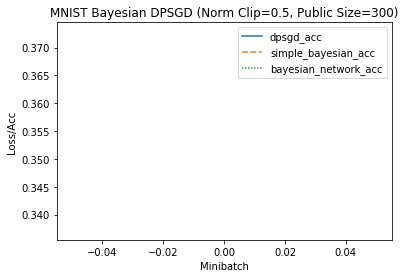

In [17]:
ax = sns.lineplot(data=metrics[:200])
ax.set(xlabel='Minibatch', ylabel='Loss/Acc', 
       title='MNIST Bayesian DPSGD (Norm Clip={}, Public Size={})'.format(l2_norm_clip, public_data.shape[0]))
plt.savefig('mnist_bayesian_network-pretrained_variance{}_dpsgd-norm{}.png'
            .format(public_var_multiplier, l2_norm_clip))